In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from skimage import io, transform
import glob


timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [37]:
from iterative_lda import IterativeLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Load iceberg data

In [4]:
iceberg = pandas.read_json('./data/iterative_lda/iceberg/train.json')

In [5]:
iceberg.shape

(1604, 5)

In [6]:
iceberg.head(n=20)

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0
5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",b51d18b5,36.9034,1
6,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",31da1a04,34.4751,1
7,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",56929c16,41.1769,0
8,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",525ab75c,35.7829,0
9,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",192f56eb,43.3007,0


In [7]:
band1 = np.asarray([[float(x) for x in row] for row in iceberg['band_1']])
for index, col in enumerate(band1.T):
    iceberg['band_1_{i}'.format(i=index)] = col

In [8]:
band2 = np.asarray([[float(x) for x in row] for row in iceberg['band_2']])
for index, col in enumerate(band2.T):
    iceberg['band_2_{i}'.format(i=index)] = col

In [9]:
iceberg['inc_angle'] = iceberg['inc_angle'].replace('na', None)

In [10]:
del iceberg['band_1']
del iceberg['band_2']
del iceberg['id']

In [11]:
iceberg.head()

,inc_angle,is_iceberg,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,...,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
0,43.9239,0,-27.878361,-27.154160,-28.668615,-29.537971,-29.092485,-32.834259,-32.190609,-29.538139,...,-31.594376,-32.837376,-30.010836,-33.532703,-34.288517,-30.010963,-29.095856,-30.507519,-28.672153,-29.095982
1,38.1562,0,-12.242375,-14.920305,-14.920363,-12.666336,-10.387527,-11.345262,-13.046976,-13.720695,...,-23.997662,-24.467342,-25.490454,-23.997839,-21.789646,-23.772335,-24.964108,-26.966469,-25.223524,-25.223581
2,45.2859,1,-24.603676,-24.603714,-24.871029,-23.152775,-21.532150,-21.349318,-19.411156,-22.304850,...,-30.367920,-28.956337,-25.729015,-25.149776,-25.149815,-27.018288,-25.729164,-24.095802,-25.729240,-25.729279
3,43.8306,0,-22.454607,-23.082819,-23.998013,-23.998053,-24.753868,-24.242828,-22.868555,-24.242914,...,-30.518187,-32.204647,-30.518272,-31.044893,-31.605511,-30.518400,-30.021971,-30.518484,-30.022057,-30.022099
4,35.6256,0,-26.006956,-23.164886,-23.164886,-26.891163,-25.731390,-23.793257,-22.770273,-23.578913,...,-27.540012,-27.880745,-30.264540,-26.896517,-24.244076,-24.018520,-23.798679,-25.210369,-24.958652,-25.210503


In [12]:
cols = iceberg.columns.tolist()
cols = cols[1:2] + cols[0:1] + cols[2:]
iceberg = iceberg[cols]

In [13]:
X = iceberg.as_matrix().astype(np.float64)
y = X[:,0].astype(int)
X = X[:,1:]
X.shape, y.shape

((1604, 11251), (1604,))

## Fit an LDA model to the entire data-set

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1283, 11251), (1283,), (321, 11251), (321,))

In [15]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(np.sum(lda.predict(X_train) == y_train) / y_train.shape[0])
print(np.sum(lda.predict(X_test) == y_test) / y_test.shape[0])

0.816835541699
0.728971962617


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## And an Iterative LDA model

In [52]:
# raise ValueError('Dont run again')
ilda = IterativeLDA(10, use_coef=False, verbose=True)
transformed_X_train = ilda.fit_transform(X_train, y_train)
transformed_X_test = ilda.transform(X_test)

Fitting component 1


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 2
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 3
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 4
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 5
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 6
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 7
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 8
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 9
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 10
Using scalings
Computing nullspace
Projecting onto nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting trans

In [39]:
rfc = RandomForestClassifier(verbose=True)
rfc.fit(transformed_X_train, y_train)

print(np.sum(rfc.predict(transformed_X_train) == y_train) / y_train.shape[0])
print(np.sum(rfc.predict(transformed_X_test) == y_test) / y_test.shape[0])

1.0
0.557632398754


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [40]:
svm = SVC(verbose=True)
svm.fit(transformed_X_train, y_train)

print(np.sum(svm.predict(transformed_X_train) == y_train) / y_train.shape[0])
print(np.sum(svm.predict(transformed_X_test) == y_test) / y_test.shape[0])

[LibSVM]1.0
0.529595015576


## Plot the first 2d projections

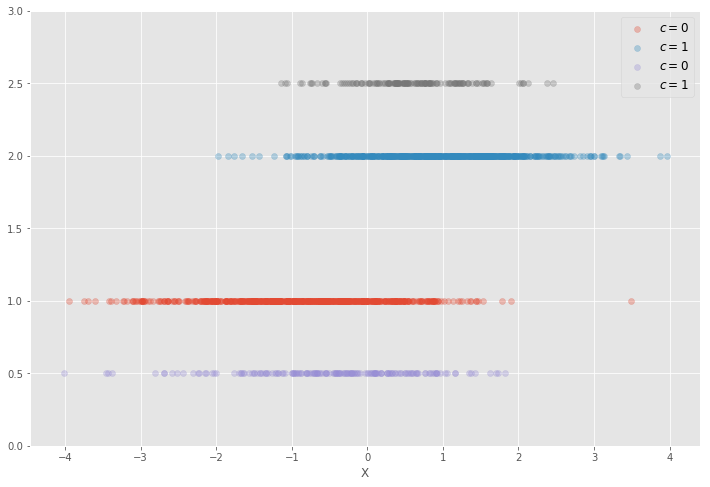

In [41]:
train_0 = y_train == 0
train_1 = y_train == 1
test_0 = y_test == 0
test_1 = y_test == 1

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

ax.scatter(transformed_X_train[train_0][:,0], [1] * np.sum(train_0), 
           label='$c=0$', alpha=0.33)
ax.scatter(transformed_X_train[train_1][:,0], [2] * np.sum(train_1), 
           label='$c=1$', alpha=0.33)

ax.scatter(transformed_X_test[test_0][:,0], [0.5] * np.sum(test_0), 
           label='$c=0$', alpha=0.33)
ax.scatter(transformed_X_test[test_1][:,0], [2.5] * np.sum(test_1), 
           label='$c=1$', alpha=0.33)

ax.set_ylim(0, 3)
ax.legend(loc='best', fontsize=12)
ax.set_xlabel('X', size=12)

plt.show()

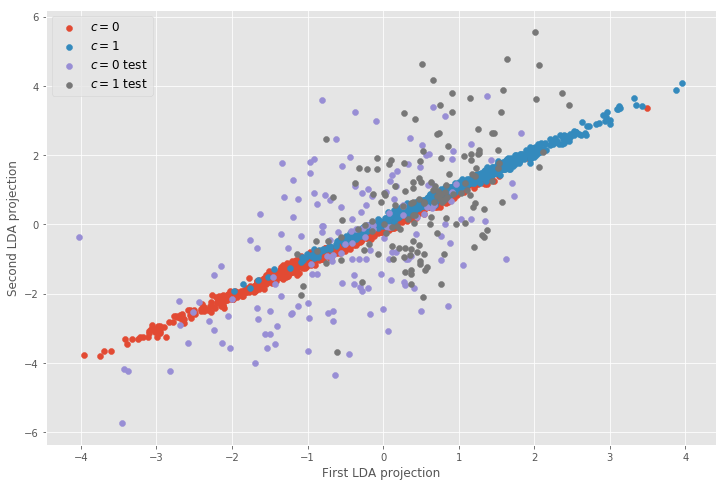

In [42]:
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

ax.scatter(transformed_X_train[train_0][:,0], transformed_X_train[train_0][:,1], label='$c=0$')
ax.scatter(transformed_X_train[train_1][:,0], transformed_X_train[train_1][:,1], label='$c=1$')

ax.scatter(transformed_X_test[test_0][:,0], transformed_X_test[test_0][:,1], label='$c=0$ test')
ax.scatter(transformed_X_test[test_1][:,0], transformed_X_test[test_1][:,1], label='$c=1$ test')

ax.legend(loc=2, fontsize=12)
ax.set_xlabel('First LDA projection', size=12)
ax.set_ylabel('Second LDA projection', size=12)

plt.show()

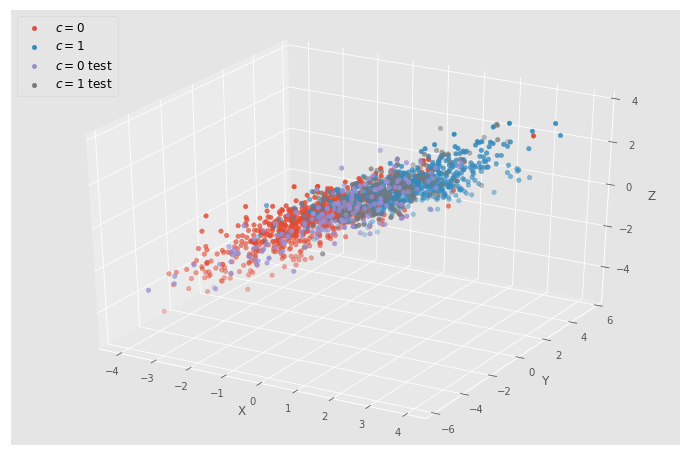

In [43]:
FONT_SIZE = 12

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed_X_train[train_0][:,0], transformed_X_train[train_0][:,1], 
           transformed_X_train[train_0][:,2], label='$c=0$')
ax.scatter(transformed_X_train[train_1][:,0], transformed_X_train[train_1][:,1],
           transformed_X_train[train_1][:,2], label='$c=1$')

ax.scatter(transformed_X_test[test_0][:,0], transformed_X_test[test_0][:,1], 
           transformed_X_test[test_0][:,2], label='$c=0$ test')
ax.scatter(transformed_X_test[test_1][:,0], transformed_X_test[test_1][:,1], 
           transformed_X_test[test_1][:,2], label='$c=1$ test')

ax.legend(loc=2, fontsize=FONT_SIZE)
ax.set_xlabel('X', size=FONT_SIZE)
ax.set_ylabel('Y', size=FONT_SIZE)
ax.set_zlabel('Z', size=FONT_SIZE)

## Let's try cross-validating an SVM model

In [44]:
# report function from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import lognorm

svm = SVC(verbose=True)
search_cv = RandomizedSearchCV(svm, cv=5, n_iter=10, scoring='accuracy', n_jobs=4, 
                               verbose=1, random_state=RANDOM_SEED,
                              param_distributions={'C': lognorm(s=4)})

search_cv.fit(X=transformed_X_train, y=y_train)
report(search_cv.cv_results_)

# print(np.sum(svm.predict(transformed_X_train) == y_train) / y_train.shape[0])
# print(np.sum(svm.predict(transformed_X_test) == y_test) / y_test.shape[0])


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LibSVM]Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 0.27931530203681859}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 0.10212031731892578}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 0.4202467648900966}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 2.7718007596242757}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 0.55002048923908065}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 3112.3404998416872}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 0.67899831484887729}

Model with rank: 1
Mean validation score: 0.999 (std: 0.002)
Parameters: {'C': 5.4130171814899652}



[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.8s finished


## Compare scalings and coefficients

In [46]:
ilda_coef = IterativeLDA(10, use_coef=True, verbose=True)
transformed_X_train_coef = ilda_coef.fit_transform(X_train, y_train)
transformed_X_test_coef = ilda_coef.transform(X_test)

Fitting component 1


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Computing nullspace
Projecting onto nullspace
Fitting component 2
Computing nullspace
Projecting onto nullspace
Fitting component 3
Computing nullspace
Projecting onto nullspace
Fitting component 4
Computing nullspace
Projecting onto nullspace
Fitting component 5
Computing nullspace
Projecting onto nullspace
Fitting component 6
Computing nullspace
Projecting onto nullspace
Fitting component 7
Computing nullspace
Projecting onto nullspace
Fitting component 8
Computing nullspace
Projecting onto nullspace
Fitting component 9
Computing nullspace
Projecting onto nullspace
Fitting component 10
Computing nullspace
Projecting onto nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting transform
Computing nullspace
Starting

In [47]:
for i in range(ilda.n_components):
    print(i, np.allclose(ilda.nullspaces_[i], ilda_coef.nullspaces_[i]))
    

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True


In [48]:
for i in range(ilda.n_components):
    print(i, np.allclose(transformed_X_train[:,i], transformed_X_train_coef[:,i]))


0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True


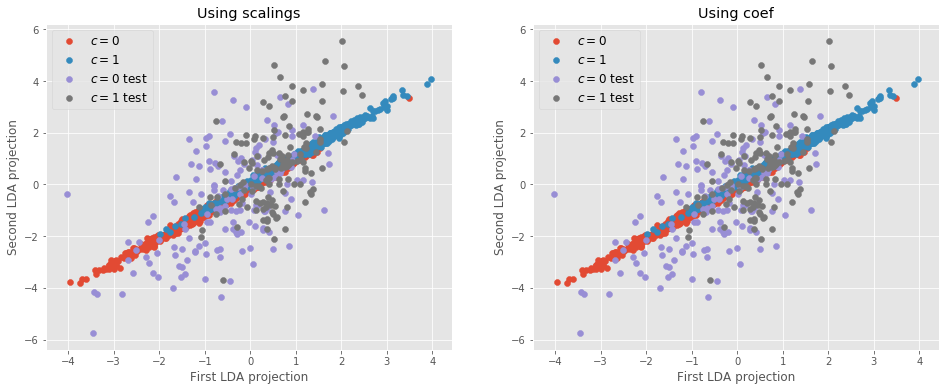

In [49]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, hspace=0.7)

def plot_components(ax, X_train, X_test, y_train, y_test):
    train_0 = y_train == 0
    train_1 = y_train == 1
    test_0 = y_test == 0
    test_1 = y_test == 1
    
    ax.scatter(X_train[train_0][:,0], X_train[train_0][:,1], label='$c=0$')
    ax.scatter(X_train[train_1][:,0], X_train[train_1][:,1], label='$c=1$')

    ax.scatter(X_test[test_0][:,0], X_test[test_0][:,1], label='$c=0$ test')
    ax.scatter(X_test[test_1][:,0], X_test[test_1][:,1], label='$c=1$ test')

    ax.legend(loc=2, fontsize=12)
    ax.set_xlabel('First LDA projection', size=12)
    ax.set_ylabel('Second LDA projection', size=12)


left_ax = plt.subplot(gs[0, 0])    
plot_components(left_ax, transformed_X_train, transformed_X_test, y_train, y_test)
left_ax.set_title('Using scalings')

right_ax = plt.subplot(gs[0, 1])
plot_components(right_ax, transformed_X_train_coef, transformed_X_test_coef, y_train, y_test)
right_ax.set_title('Using coef')

plt.show()

In [50]:
del(ilda)
del(ilda_coef)
del(transformed_X_train)
del(transformed_X_train_coef)
del(transformed_X_test)
del(transformed_X_test_coef)

## Compare QR and SVD speeds

In [31]:
SOLVERS = ('qr', 'svd')
fit_times = {}

max_components = 10

for solver in SOLVERS:
    print(solver)
    fit_times[solver] = []
    for i in range(1, max_components + 1):
        print(i)
        def fit_function():
            return IterativeLDA(i, nullspace_solver=solver).fit(X_train, y_train)

        fit_time, train_result = timeit.timeit(fit_function, number=1)
        fit_times[solver].append(fit_time)
        del(train_result)

qr
1


/opt/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


2
3
4
5
6
7
8
9
10
svd
1
2
3
4
5
6
7
8
9
10


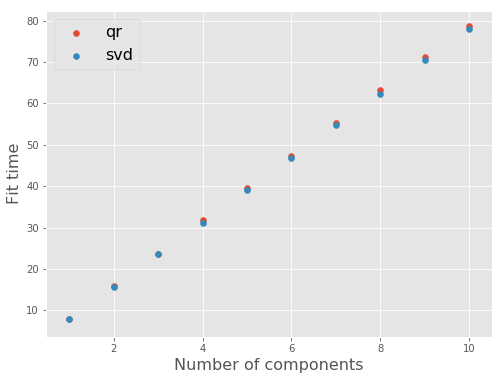

In [36]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

for solver in SOLVERS:
    ax.scatter(range(1, max_components + 1), fit_times[solver], label=solver)

ax.legend(loc=2, fontsize=16)
ax.set_xlabel('Number of components', size=16)
ax.set_ylabel('Fit time', size=16)

plt.show()

In [35]:
print(fit_times)

{'qr': [7.901548539999567, 15.822822977000214, 23.6897097810006, 31.791566775999854, 39.501620297000045, 47.30241362400011, 55.2234032639999, 63.175939650000146, 71.12939923199974, 78.82557212400025], 'svd': [7.912211683000351, 15.636714182000105, 23.568012804999853, 31.060931695000363, 39.07552064999982, 46.925241412000105, 54.799428047999754, 62.2484585279999, 70.55669646199931, 78.020815717]}


In [56]:
transformed_X_train[0]

array([-2.04882058, -2.00469788, -2.54515869, -2.04546898, -2.29869416,
       -2.04078742, -2.24290485, -2.44506969, -2.51146564, -2.11760614])